In [1]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

import matplotlib.pyplot as plt
import pandas as pd
import torch

import numpy as np
import matplotlib.pyplot as plt
import os

/Users/david/TimeSeries/HW13/venv/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
dirname = os.path.join(os.path.abspath(os.curdir), 'data', 'underwork')

raw_data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}
for v in raw_data:
    tsdf_c = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    tsdf_w = pd.read_csv(os.path.join(os.sep, dirname, v,  'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    raw_data[v] = (tsdf_c, tsdf_w, tsdf_m)

In [3]:
data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}

for v in raw_data:
    calm = raw_data[v][0]
    work = raw_data[v][1]
    sex = raw_data[v][2].iloc[0]["values"]
    weight = raw_data[v][2].iloc[1]["values"]
    height = raw_data[v][2].iloc[2]["values"]
    calm["sex"] = sex
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work["sex"] = sex
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    data[v] = (calm, work)

In [4]:
validation = {"25":(), "27":()}
for v in validation:
    calm = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    work = pd.read_csv(os.path.join(os.sep, dirname, v,  'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    sex = tsdf_m.iloc[0]["values"]
    weight = tsdf_m.iloc[1]["values"]
    height = tsdf_m.iloc[2]["values"]
    calm["sex"] = sex
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work["sex"] = sex
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    validation[v] = (calm, work)

In [5]:
ts = pd.DataFrame()

for v in data:
   calm = data[v][0]
   work = data[v][1]
   ts = pd.concat([ts, calm, work], sort=False, axis=0)

In [6]:
ts.index = np.arange(len(ts.index))
ts.index = pd.to_datetime(ts.index)
sec = 1000000000
delta = pd.to_datetime(2 * sec) - pd.to_datetime(sec)
times = [pd.to_datetime(sec)]
for i in range(1, len(ts.index)):
    times += [times[i - 1] + delta]
ts.index = times

In [7]:
pdts_data = PandasDataset(ts, freq='S', target='1')
test_size = 5000
train,test = split(pdts_data, offset=-test_size)

In [8]:
EPOCHS = 4
model = DeepAREstimator(freq='S', prediction_length=test_size, trainer_kwargs={'max_epochs':EPOCHS})

In [9]:
predictor = model.train(train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/david/TimeSeries/HW13/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/david/TimeSeries/HW13/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: /Users/david/TimeSeries/HW13/lightning_logs

  | Name  | Type        | Params | In s

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.40986 (best 0.40986), saving model to '/Users/david/TimeSeries/HW13/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached -0.89744 (best -0.89744), saving model to '/Users/david/TimeSeries/HW13/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached -1.25792 (best -1.25792), saving model to '/Users/david/TimeSeries/HW13/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=4` reached.


In [10]:
test = test.generate_instances(prediction_length = test_size, windows=1)
forecast = list(predictor.predict(test.input))

1


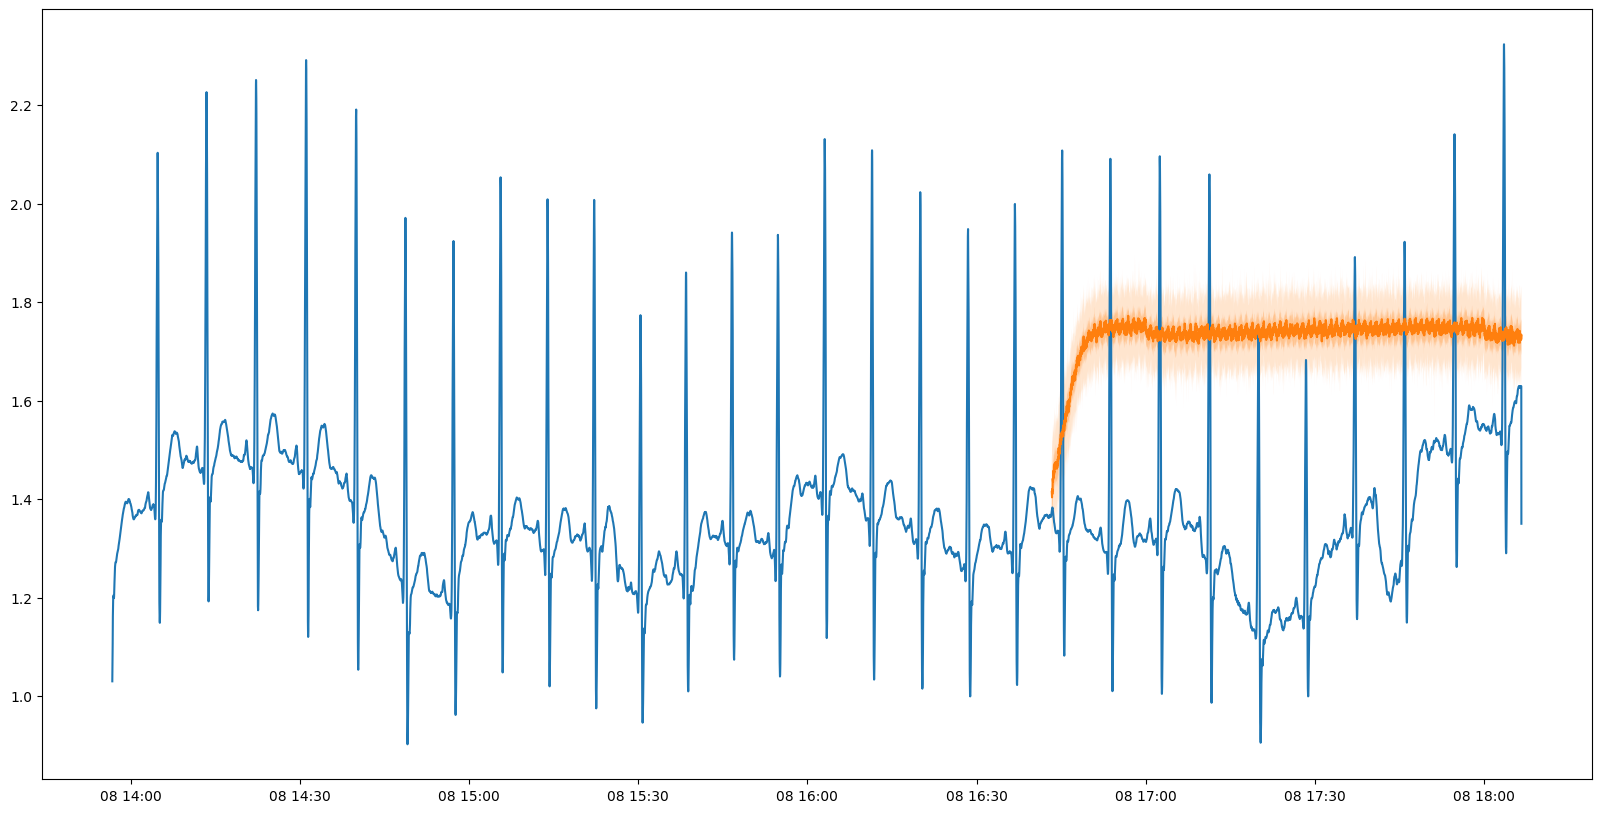

In [11]:
plt.figure(figsize=(20,10))
print(len(forecast))
plt.plot(ts['1'][len(ts['1']) - 3 * test_size:len(ts['1'])])
for fore in forecast:
    fore.plot()

In [12]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
print("RMSE:", np.sqrt(mean_squared_error(ts['1'][len(ts['1']) - len(forecast[0].samples[0]):len(ts['1'])], forecast[0].samples[0])))
print("MAPE:", mean_absolute_percentage_error(ts['1'][len(ts['1']) - len(forecast[0].samples[0]):len(ts['1'])], forecast[0].samples[0]))
print("MAE:", mean_absolute_error(ts['1'][len(ts['1']) - len(forecast[0].samples[0]):len(ts['1'])], forecast[0].samples[0]))
print("R2: ", r2_score(ts['1'][len(ts['1']) - len(forecast[0].samples[0]):len(ts['1'])], forecast[0].samples[0]))

RMSE: 0.41464506977664195
MAPE: 0.2985268398562808
MAE: 0.3855035554253159
R2:  -4.689011660948371
